In [0]:
# Taken from https://github.com/GunhoChoi/AnoGAN-Pytorch

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" # set gpu number to use


from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline
from IPython.display import clear_output
import random
import itertools
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from tqdm import tqdm_notebook
from torch.nn.functional import logsigmoid

# Постановка задачи

Задача поиска аномалий - находить объекты, отличные от нормальных данных

**Примеры:** поиск сбоев, атак, ботов и другого аномального поведения или объектов

Как правило, ***основное отличие задачи поиска аномалий от задачи бинарной классификации*** заключается в том, что ***аномалий*** в выборке ***намного меньше или нет вообще***!

В связи с этим, большинство алгоритмов поиска аномалий, таких как OneClass-SVM и Isolation Forest, основываются на ***гипотезе о компактности***, когда нормальные объекты образуют некоторый кластер или группу кластеров (см. рис. ниже), а аномалии выходят за пределы этих кластеров
![](https://developer.mindsphere.io/apis/analytics-anomalydetection/images/DBSCAN.png)


Для экспериментов будем использовать датасет рукописных цифр MNIST

In [2]:
anomaly_digit = 0 # какую цифру примем за аномалию

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
api = 'GGF21Vtrnid3Cgat9n1nL9Vcc'

In [3]:
# Зададим обучающую и тестовую выборки в PyTorch

def sample_noise(batch_size, dim):
    normal = torch.distributions.Normal(loc=0, scale=1)
    return normal.sample((batch_size, dim))

def shuffle(a,b):
    assert len(a) == len(b)
    start_state = random.getstate()
    random.shuffle(a)
    random.setstate(start_state)
    random.shuffle(b)

def fixed_anomaly_loader(anomaly_num, is_train=True, batch_size=256):
    mnist_train0 = dset.MNIST("../../../data", train=is_train, 
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5]),
                            ]),
                            target_transform=None,
                            download=True)
    
    idx = mnist_train0.targets==anomaly_digit
    anomaly_num = min(anomaly_num, idx.sum().item())
    mnist_train0.targets = mnist_train0.targets[idx]
    mnist_train0.data = mnist_train0.data[idx]

    el = len((mnist_train0.targets))
    shuffle(mnist_train0.targets, mnist_train0.data)
    mnist_train0.targets = mnist_train0.targets[[True] * anomaly_num + [False] * (el - anomaly_num)]
    mnist_train0.data = mnist_train0.data[[True] * anomaly_num + [False] * (el - anomaly_num)]


    mnist_train1 = dset.MNIST("../../../data", train=is_train, 
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5]),
                            ]),
                            target_transform=None,
                            download=True)

    idx = mnist_train1.targets!=anomaly_digit
    mnist_train1.targets = mnist_train1.targets[idx]
    mnist_train1.data = mnist_train1.data[idx]

    ds = torch.utils.data.ConcatDataset([mnist_train0, mnist_train1])

    loader = torch.utils.data.DataLoader(dataset=ds, batch_size=batch_size,shuffle=True, drop_last=True)
    # DataLoader - вспомогательный класс PyTorch, который разбивает данные на батчи
    return loader

# Baseline
В качестве бейслайна попробуем обучить бинарный классификатор (аномалия/не аномалия) в условиях малого количества аномалий

## Задание 1
Обучите бинарный классификатор для поиска аномалий. Посмотрите на финальный ROC AUC 

In [4]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
            #nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, kernel_size=7, padding=3),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2), # 128 x 7 x 7
            nn.LeakyReLU(),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
model = AlexNet(num_classes=1)
model.to(device)
num_classes=1
criterion = nn.BCEWithLogitsLoss() # бинарная кросс-энтропия 
opt = torch.optim.Adam(model.parameters(), lr=0.005) # оптимизатор

num_anomalies = 50 # количество используемых аномалий. В обучении не должно использоваться больше указанного числа!
epoch = 25 # сколько циклов обучения (сколько раз прогоним всю обучаюшую выборку в процессе обучения)

In [5]:
torch.cuda.empty_cache()

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/a08175ca31b54e1ea8a35ef332b39efa



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/a08175ca31b54e1ea8a35ef332b39efa
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount             : (10.0, 10.0)
COMET INFO:     bin cross entropy loss [5300]: (1.5366812533557095e-07, 0.7516442537307739)
COMET INFO:     loss [530]                   : (1.9464624756437843e-07, 0.7516442537307739)
COMET INFO:     roc auc [25]                 : (0.9992461197339246, 1.0)
COMET INFO:     sys.gpu.0.free_memory [8]    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization [8]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [8]    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory [8]    : (8824160256.0, 10645536768.0)
COMET INFO:     sys.gpu.1.gpu_utilization [8]: (0.0, 97.0)
COMET INF


Epoch: 24	 Loss: 4.669844315685623e-07 ROC AUC: 0.99989889135255


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/70da71325f4746cd8ae8b13ad06bdae0



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/70da71325f4746cd8ae8b13ad06bdae0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount             : (50.0, 50.0)
COMET INFO:     bin cross entropy loss [5325]: (4.6566125955216364e-10, 0.055848971009254456)
COMET INFO:     loss [533]                   : (8.381899618825628e-09, 0.031237728893756866)
COMET INFO:     roc auc [25]                 : (0.9983880266075388, 0.9999889135254989)
COMET INFO:     sys.gpu.0.free_memory [8]    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization [8]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [8]    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory [8]    : (8824160256.0, 8824160256.0)
COMET INFO:     sys.gpu.1.gpu_utilization [8]: (0.0


Epoch: 24	 Loss: 2.549839518906083e-05 ROC AUC: 0.9997059866962306


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/e237dd7982554d14aa558812a11b9429



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/e237dd7982554d14aa558812a11b9429
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount             : (100.0, 100.0)
COMET INFO:     bin cross entropy loss [5350]: (0.0, 0.06542793661355972)
COMET INFO:     loss [535]                   : (0.0, 0.040362872183322906)
COMET INFO:     roc auc [25]                 : (0.9999844789356984, 1.0)
COMET INFO:     sys.gpu.0.free_memory [9]    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization [9]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [9]    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory [9]    : (8824160256.0, 8824160256.0)
COMET INFO:     sys.gpu.1.gpu_utilization [9]: (0.0, 97.0)
COMET INFO:     sys.gpu.1.total_memory     


Epoch: 24	 Loss: 2.656169044712442e-07 ROC AUC: 0.9999976496674057


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/5d4adfaf1cbc40e083986627a155bf4f



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/5d4adfaf1cbc40e083986627a155bf4f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount             : (500.0, 500.0)
COMET INFO:     bin cross entropy loss [5575]: (1.2572849428238442e-08, 0.06828972697257996)
COMET INFO:     loss [558]                   : (7.543685853761417e-08, 0.04660510644316673)
COMET INFO:     roc auc [25]                 : (0.9999858093126386, 0.9999997782705101)
COMET INFO:     sys.gpu.0.free_memory [9]    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization [9]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [9]    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory [9]    : (8824160256.0, 8824160256.0)
COMET INFO:     sys.gpu.1.gpu_utilization [9]: (0.0


Epoch: 24	 Loss: 1.4580115248463699e-06 ROC AUC: 0.9999952106430154


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/48c2042889164df5b706976120263408



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/48c2042889164df5b706976120263408
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount             : (1000.0, 1000.0)
COMET INFO:     bin cross entropy loss [5875]: (1.9557756303356655e-08, 0.07437877357006073)
COMET INFO:     loss [588]                   : (2.933663623139182e-08, 0.024028640240430832)
COMET INFO:     roc auc [25]                 : (0.9999787320693245, 0.9999985293452194)
COMET INFO:     sys.gpu.0.free_memory [9]    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization [9]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [9]    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory [9]    : (8824160256.0, 8824160256.0)
COMET INFO:     sys.gpu.1.gpu_utilization [9]: (


Epoch: 24	 Loss: 6.466155355155934e-06 ROC AUC: 0.9999941264310601


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/1fb3ff9e235e4cefafed253d273c372d




Epoch: 24	 Loss: 9.400026783623616e-07 ROC AUC: 0.9999290782388343


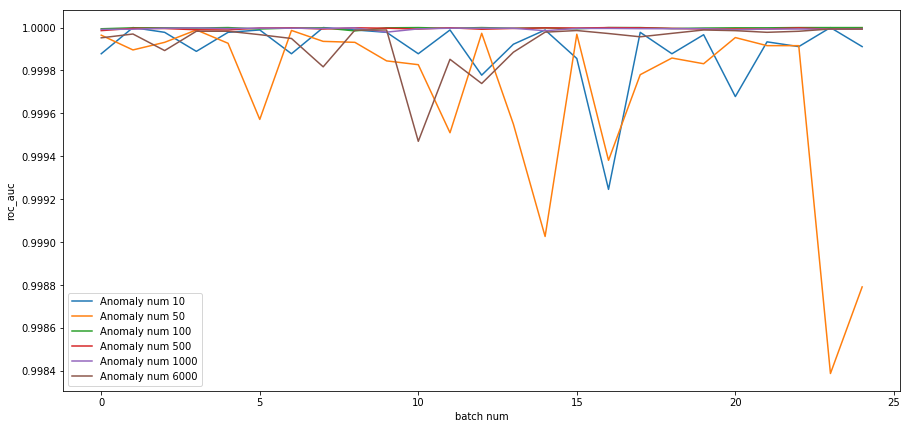

In [6]:
plt.figure(figsize=(15,7))
for anomaly_num in [10, 50, 100, 500, 1000, 6000]:
    experiment = Experiment(api_key=api, project_name="roc_auc mnist", workspace="comet-ml testing")
    experiment.log_metric("anomalies amount", anomaly_num)
    train_loader = fixed_anomaly_loader(anomaly_num * 6)
    test_loader = fixed_anomaly_loader(anomaly_num, False, 512)
    roc_aucs = []
    for i in tqdm_notebook(range(epoch)):
        model.train()
        for j,(image,label) in enumerate(train_loader):
            image = image.to(device)
            label = label.view(len(label), 1).float()
            label = label.to(device)
            predict = model(image)
            loss = criterion(predict, (label != anomaly_digit).float())
            experiment.log_metric("bin cross entropy loss", loss.cpu().detach().numpy())
            loss.backward()
            opt.step()
            opt.zero_grad()  
        model.eval()
        roc_auc = 0 
        predictions, labels = np.array([]), np.array([])
        for j,(image,label) in enumerate(test_loader):
            predict = model(image.to(device))
            if predictions.size == 0:
                predictions = predict.view(predict.shape[0]).cpu().detach().numpy()
                labels = label
            else:
                predictions = np.hstack((predictions, predict.view(predict.shape[0]).cpu().detach().numpy()))
                labels = np.hstack((labels, label))
        roc_auc = roc_auc_score((labels != anomaly_digit).astype(int), predictions)
        experiment.log_metric("roc auc", roc_auc)
        roc_aucs.append(roc_auc)
    print(f'Epoch: {i}\t Loss: {loss.item()} ROC AUC: {np.array(roc_aucs).mean()}')
    plt.plot(roc_aucs, label="Anomaly num {}".format(anomaly_num))
    plt.xlabel("batch num")
    plt.ylabel("roc_auc")
plt.legend()

In [6]:
print(device)

cuda


# AnoGAN

Основная идея [AnoGAN](https://arxiv.org/abs/1703.05921) - находить аномалии на основе расстояния до ближайшего соседа в пространстве латентных переменных. Алгоритм состоит из двух этапов:
1. На первом этапе обучается дискриминатор и генератор в стандартном режиме на нормальных объектах. При этом предполается, что генератор выучивает некоторое преобразование из латентного многообразия Z в пространство нормальных объектов
2. На втором этапе для каждого нового объекта считается расстояние до латентного многообразия, в котором сконцентрированы нормальные объекты. Те объекты, расстояние от которых до многообразия слишком большое, принимаются за аномалии

![](https://i.ibb.co/ZmzwMfS/image.png)

# AnoGAN. Этап 1. Обучение генератора на нормальных объектах

## JS GAN MNIST

In [7]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*128),
             nn.BatchNorm1d(7*7*128),
             nn.ReLU(),
             nn.Linear(7*7*128, 7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
            
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,32,3,2,1,1),
                        nn.BatchNorm2d(32),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(32,16,5,1,2),
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(16,1,7,1,3), #added for GP not present in JS
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [8]:
# Discriminator receives 1x28x28 image and returns a float number
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 16, kernel_size=7,padding=3),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(16,32,kernel_size=5,padding=2),  # batch x 32 x 14 x 14
                        nn.BatchNorm2d(32),    
                        nn.LeakyReLU(),
                        nn.MaxPool2d(kernel_size=2) #batch x 32 x 7 x 7
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(32, 16, kernel_size=3,padding=1),  # batch x 32 x 7 x 7
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
                        nn.Linear(16*3*3, 1)
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [9]:
from torchsummary import summary

generator = Generator().to(device)
discriminator = Discriminator().to(device)

summary(generator, (100, ))
summary(discriminator, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
       BatchNorm1d-2                 [-1, 6272]          12,544
              ReLU-3                 [-1, 6272]               0
            Linear-4                [-1, 25088]     157,377,024
       BatchNorm1d-5                [-1, 25088]          50,176
              ReLU-6                [-1, 25088]               0
   ConvTranspose2d-7          [-1, 256, 14, 14]       1,179,904
       BatchNorm2d-8          [-1, 256, 14, 14]             512
         LeakyReLU-9          [-1, 256, 14, 14]               0
  ConvTranspose2d-10          [-1, 128, 14, 14]         295,040
      BatchNorm2d-11          [-1, 128, 14, 14]             256
        LeakyReLU-12          [-1, 128, 14, 14]               0
  ConvTranspose2d-13           [-1, 64, 14, 14]          73,792
      BatchNorm2d-14           [-1, 64,

In [10]:
#GAN - JS

gen_opt = torch.optim.RMSprop(generator.parameters(), lr=1e-3)
disc_opt = torch.optim.RMSprop(discriminator.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_n_test(epochs, lmbd=10):
    BATCH_SIZE = 256
    experiment = Experiment(api_key=api, project_name="MNIST GAN-JS", workspace="comet-ml testing")
    k, m = 2, 4
    with experiment.train():
        for epoch in tqdm_notebook(range(epochs)):
            train_loader = iter(fixed_anomaly_loader(0, BATCH_SIZE))
            n = len(train_loader)
            for i in range(n // k):
                for _ in range(k):
                    disc_opt.zero_grad()
                    noise = sample_noise(BATCH_SIZE, 100)
                    gen_data = generator(noise.to(device))
                    real_data, _ = next(train_loader)
                    real_data = real_data.to(device)
                    disc_fake, _ = discriminator(gen_data)
                    disc_real, _ = discriminator(real_data)
                    disc_loss = -logsigmoid(disc_real).mean() - logsigmoid(-disc_fake).mean()
                    experiment.log_metric("discriminator loss", disc_loss.cpu().detach().numpy())
                    disc_loss.backward()
                    disc_opt.step()
                for _ in range(m):
                    gen_opt.zero_grad() 
                    noise = sample_noise(BATCH_SIZE, 100).to(device)
                    gen_data = generator(noise)
                    if (i % 10) == 0:
                        plt.figure(figsize = (15,10))
                        plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])
                        experiment.log_figure()
                        plt.close('all')
                    disc, _ = discriminator(gen_data)
                    gen_loss = -logsigmoid(disc).mean()
                    experiment.log_metric("genetator loss", gen_loss.cpu().detach().numpy())
                    gen_loss.backward()
                    gen_opt.step() 
            plt.figure(figsize = (15,10))
            plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])
            experiment.log_figure()
        experiment.end() 

In [11]:
def yet_another_iteration(k=5):
    train_n_test(k)
    noise = sample_noise(256, 100).to(device)
    gen_data = generator(noise)
    plt.figure(figsize = (15,10))
    plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/mnist-gan-js/d49b0ab49ed945b7abc0f63805a212e9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory              : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization          : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory             : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory              : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory              : (4038459392.0, 4038459392.0)
COMET INFO:     sys.gpu.1.gpu_utilization          : (0.0, 0.0)
COMET INFO:     sys.gpu.1.total_memory             : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory              : (7957118976.0, 7957118976.0)
COMET INFO:     sys.gpu.2.free_memory              : (9537847296.0, 9537847296.0)
COMET INFO:     sys.gpu.2.gpu_utilization    

COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded


COMET INFO:     sys.gpu.2.total_memory              : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.2.used_memory               : (2457731072.0, 2457731072.0)
COMET INFO:     sys.gpu.3.free_memory               : (8426094592.0, 8426094592.0)
COMET INFO:     sys.gpu.3.gpu_utilization           : (85.0, 85.0)
COMET INFO:     sys.gpu.3.total_memory              : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.3.used_memory               : (3569483776.0, 3569483776.0)
COMET INFO:     train_discriminator loss [2120]     : (1.184204339981079, 2.612412929534912)
COMET INFO:     train_genetator loss [4240]         : (0.0948207676410675, 0.9308806657791138)
COMET INFO:     train_loss [636]                    : (0.43621504306793213, 1.568996787071228)
COMET INFO:     train_sys.gpu.0.free_memory [56]    : (9388556288.0, 9388556288.0)
COMET INFO:     train_sys.gpu.0.gpu_utilization [56]: (0.0, 0.0)
COMET INFO:     train_sys.gpu.0.used_memory [56]    : (2607022080.0, 2607022080.0)


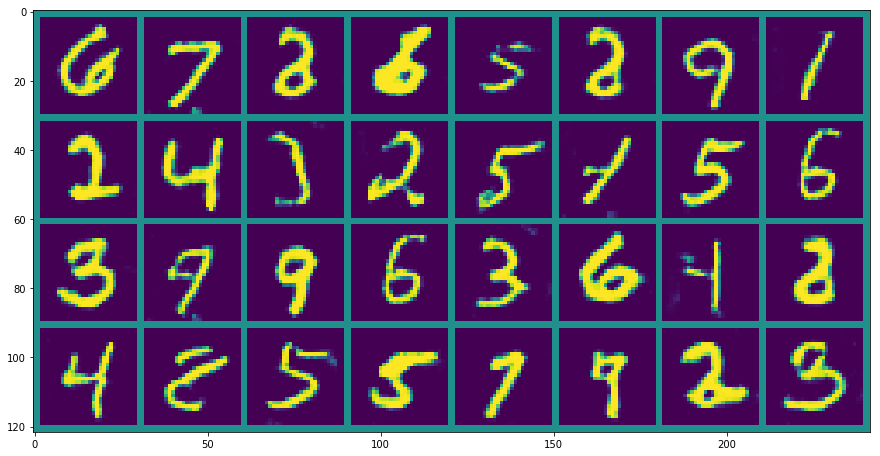

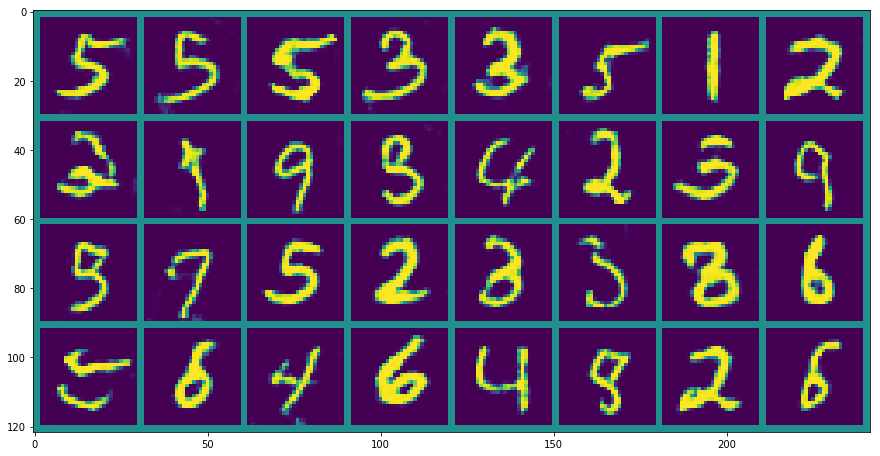

In [58]:
yet_another_iteration(10)

In [11]:
generator.load_state_dict(torch.load('./models/generator_vanilla_gan_mnist.ckpt'))
discriminator.load_state_dict(torch.load('./models/discriminator_vanilla_gan_mnist.ckpt'))

<All keys matched successfully>

In [13]:
gen_opt = torch.optim.RMSprop(generator.parameters(), lr=1e-3)
disc_opt = torch.optim.RMSprop(discriminator.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_n_test_GP(epochs, lmbd=10):
    BATCH_SIZE = 256
    experiment = Experiment(api_key=api, project_name="mnist GAN", workspace="comet-ml testing")
    k, m = 2, 3
    with experiment.train():
        generator.train()
        discriminator.train()
        for epoch in tqdm_notebook(range(epochs)):
            train_loader = iter(fixed_anomaly_loader(0, batch_size=BATCH_SIZE))
            for i in range(len(train_loader) // k):
                for _ in range(k):
                    disc_opt.zero_grad()
                    noise = sample_noise(BATCH_SIZE, 100)
                    gen_data = generator(noise.to(device))
                    real_data, _ = next(train_loader)
                    real_data = real_data.to(device)
                    t = torch.rand(BATCH_SIZE, 1, 1, 1).to(device)
                    t = t.expand(gen_data.size())
                    in_between = t * real_data.to(device)+ (1 - t) * gen_data.to(device)
                    in_between = torch.autograd.Variable(in_between, requires_grad=True)
                    disc_in_between, _ = discriminator(in_between)
                    gradients = torch.autograd.grad(outputs=disc_in_between, inputs=in_between,
                                      grad_outputs=torch.ones(disc_in_between.data.size()).to(device),
                                      create_graph=True, retain_graph=True, only_inputs=True)[0]
                    disc_fake, _ = discriminator(gen_data)
                    disc_real, _ = discriminator(real_data)

                    disc_loss = disc_fake.mean() - disc_real.mean() +\
                            ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lmbd

                    experiment.log_metric("discriminator loss", disc_loss.cpu().detach().numpy())
                    disc_loss.backward()
                    disc_opt.step()
                for _ in range(m):
                    gen_opt.zero_grad() 
                    noise = sample_noise(BATCH_SIZE, 100).to(device)
                    gen_data = generator(noise)
                    if (i % 10) == 0:
                        plt.figure(figsize = (15,10))
                        plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])
                        experiment.log_figure()
                        plt.close('all')
                    disc, _ = discriminator(gen_data)
                    gen_loss = -disc.mean()
                    experiment.log_metric("genetator loss", gen_loss.cpu().detach().numpy())
                    gen_loss.backward()
                    gen_opt.step() 
        experiment.end() 

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/mnist-gan/56e5c1ce4ca447bea99e0a07709af35e



COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded


COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


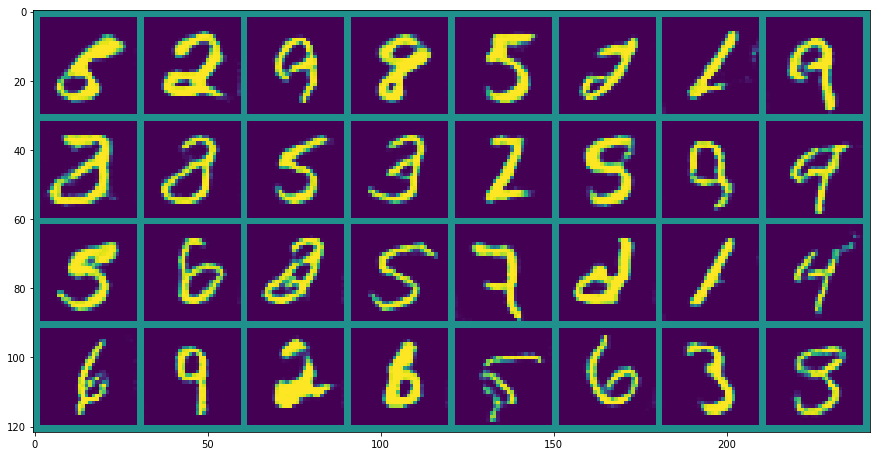

In [12]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_opt = torch.optim.RMSprop(generator.parameters(), lr=1e-3)
disc_opt = torch.optim.RMSprop(discriminator.parameters(), lr=1e-3)

train_n_test_GP(3)
noise = sample_noise(256, 100).to(device)
gen_data = generator(noise)
plt.figure(figsize = (15,10))
plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])

In [14]:
generator.load_state_dict(torch.load('./models/generator_wasserstein_gan_mnist.ckpt'))
discriminator.load_state_dict(torch.load( './models/discriminator_wasserstein_gan_mnist.ckpt'))

<All keys matched successfully>

## Задание 2
Обучите GAN любым удобным вам способом

**Внимание:** обучайте GAN только на **нормальных** объектах (цифрах)!

## AnoGAN. Этап 2. Подсчёт расстояния до нормальных объектов и подбор 

## Задание 3
Реализуйте расстояние до аномалий согласно формуле, предложенной в [статье](https://arxiv.org/abs/1703.05921):
$$L(x,G_z)=(1-\lambda)|x-G_z| + \lambda|D(x)-D(G_z)|$$, где x - аномалия (или нормальный объект), $G_z=G(z)$ - объект, сгенерированный генератором $G$ из латентного представления $z\in Z$

In [15]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1): # расстояние до аномалии x до G_z. На выходе должен возвращаться тензор (batch_size,)
    _, d1 = discriminator(x)
    _, d2 = discriminator(G_z)
    feature_dist = (d1 - d2).norm(2, dim=1)
    image_dist = (x - G_z).norm(2, dim=1)
    return image_dist.view(image_dist.shape[0], -1).mean(axis=1)**2 + Lambda * feature_dist ** 2

In [16]:
import os

start_idx = 64
train_size = 512

mnist_train = dset.MNIST("../../../data", train=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = dset.MNIST("../../../data", train=False, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

    

train_data_mnist = mnist_train.__dict__['data'][start_idx:start_idx+train_size]
train_label_mnist = mnist_train.__dict__['targets'][start_idx:start_idx+train_size] == anomaly_digit 
# 0 - нормальный объект, 1 - аномалия
train_data_mnist = train_data_mnist.view(train_size,1,28,28).type_as(torch.FloatTensor())
train_data_mnist.size()



torch.Size([512, 1, 28, 28])

## Задание 4
Теперь, имея расстояние между двумя объектами, найдите ближайших соседей в латентном пространстве $Z$ для каждого из объектов выборки train_data_mnist. Поиск ближайшего соседа для каждого из объектов производится путём градиентной минимизации расстояния по переменной $z$.

Имея теперь расстояние до ближайшего соседа для каждого объекта выборки train_data_mnist, можно интерпретировать это расстояние как скор модели - чем больше это расстояние, тем больше вероятность, что ваш объект - аномалия, и наоборот.

Посмотрите, как по мере обучения (по мере поиска ближайшего соседа) меняется это расстояние. Принимая это расстояние за скор модели, посмотрите, как по мере обучения меняется ROC AUC. Сравните результат с baseline. Стало ли лучше?

In [17]:
z = Variable(init.normal(torch.zeros(train_size,100),mean=0,std=0.1),requires_grad=True)
# для каждого объекта берём случайный нормальный объект в латентном пространстве в качестве начального соседа
z_optimizer = torch.optim.Adam([z],lr=1e-1) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям

gen_fake = generator(z.cuda())
print(gen_fake.shape, train_data_mnist.shape)
loss = Anomaly_score(Variable(train_data_mnist).cuda(),gen_fake)
# расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
print(loss.shape)
print(loss.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


torch.Size([512, 1, 28, 28]) torch.Size([512, 1, 28, 28])
torch.Size([512])
tensor(1208.9462, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
z = Variable(init.normal(torch.zeros(train_size,100),mean=0,std=0.1),requires_grad=True)
z_optimizer = torch.optim.Adam([z],lr=1e-1)
experiment = Experiment(api_key=api, project_name="roc_auc mnist AnoGAN", workspace="comet-ml testing")
roc_aucs = []
for i in tqdm_notebook(range(5000)):
    z_optimizer.zero_grad()
    gen_fake = generator(z.cuda())
    loss = Anomaly_score(Variable(train_data_mnist).cuda(), gen_fake, 10)
    roc_auc = roc_auc_score(train_label_mnist.int(), loss.cpu().detach().numpy())
    experiment.log_metric('roc_auc', roc_auc)
    roc_aucs.append(roc_auc)
    mean_dist = loss.sum()
    mean_dist.backward()
    z_optimizer.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.
COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist-anogan/ac7b3c9bcfac4c0cac8ee7cb1f94bb72
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [39]                     : (605071.1875, 610630.875)
COMET INFO:     roc_auc [387]                 : (0.8311332614942528, 0.8318516522988506)
COMET INFO:     sys.gpu.0.free_memory [10]    : (5230034944.0, 5230034944.0)
COMET INFO:     sys.gpu.0.gpu_utilization [10]: (0.0, 98.0)
COMET INFO:     sys.gpu.0.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [10]    : (6765543424.0, 6765543424.0)
COMET INFO:     sys.gpu.1.free_memory [10]    : (3222667264.0, 4485152768.0)
COMET INFO:     sys.g

In [ ]:
generator = Generator().to(device)
generator.load_state_dict(torch.load('./models/generator_wasserstein_gan_mnist.ckpt'))
gen_fake = generator(z.cuda())
loss = Anomaly_score(Variable(train_data_mnist).cuda(), gen_fake, 10)
roc_auc = roc_auc_score(train_label_mnist.int(), loss.cpu().detach().numpy())
print('roc_auc:', roc_auc)
sns.distplot(loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.title('z backprop')
plt.legend()

In [ ]:
z = torch.save('./models/z')

In [35]:
z = torch.load( './models/z.ckpt')

Text(0,0.5,'roc auc')

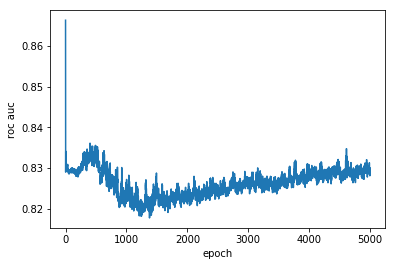

In [21]:
plt.plot(roc_aucs)
plt.xlabel('epoch')
plt.ylabel('roc auc')

## Задание 5
Посмотрим на ближайших соседей

In [104]:
def show_image(ax, title, img, dim=28):
    ax.imshow(img.reshape(dim, dim))
    ax.set_title(title)
    ax.axis('off')

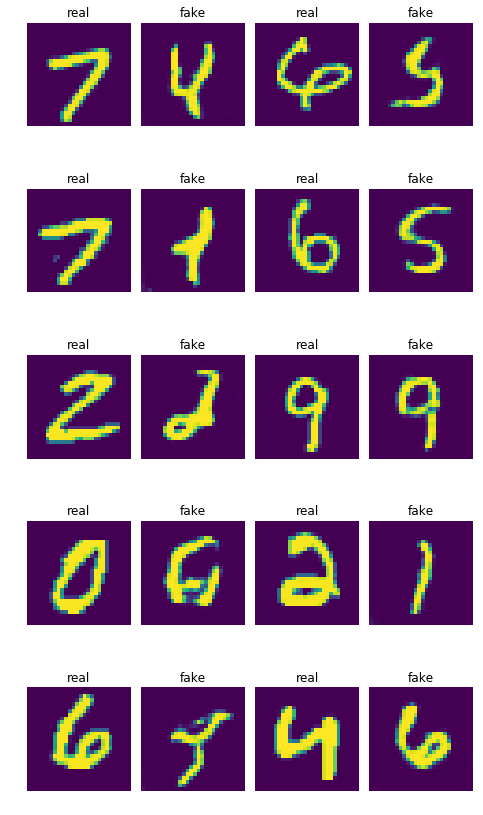

In [109]:
z = z.to(device)
pic_num = 10
indices = np.random.randint(0, train_size - 2, pic_num // 2)
dim = 28
fig, axes = plt.subplots(len(indices), 4, figsize=(8, 15), gridspec_kw={'wspace':0.1, 'hspace':0.1},
                           squeeze=True)
for i, idx in enumerate(indices):
    ax = axes[i]
    real = train_data_mnist[idx : idx + 2].cpu().detach().numpy()
    zs = z[idx : idx + 2].view(2, -1)
    fake = generator(zs.to(device)).cpu().detach().numpy()
    r1, r2 = real[0], real[1]
    f1, f2 = fake[0], fake[1]
    lbls, imgs = ['real', 'fake', 'real', 'fake'], [r1, f1, r2, f2]
    for i in range(4):
        show_image(ax[i], lbls[i], imgs[i])

## Задание 6
Построим распределение расстояний для нормальных и аномальных объектов.
Что можно сказать, глядя на это распределение?

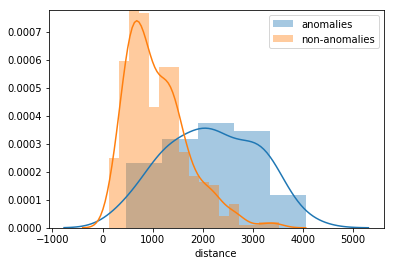

In [38]:
%matplotlib inline
import seaborn as sns
sns.distplot(loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.legend()

In [ ]:
# Discriminator receives 1x28x28 image and returns a float number
# we can name each layer using OrderedDict

class Encoder_izi_f(nn.Module):
    def __init__(self):
        super(Encoder_izi_f,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 16, kernel_size=7,padding=3),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(16,32,kernel_size=5,padding=2),  # batch x 32 x 14 x 14
                        nn.BatchNorm2d(32),    
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(32, 16, kernel_size=3,padding=1),  # batch x 16 x 14 x 14
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(16, 8, kernel_size=3,padding=1), #batch x 8 x 7 x 7 
                        nn.BatchNorm2d(8),
                        nn.LeakyReLU(),
        )
        self.fc = nn.Sequential(
                        nn.Linear(8 * 7 * 7, 100)
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

In [ ]:
encoder = Encoder_izi_f().to(device)
izi_opt = torch.optim.RMSprop(discriminator.parameters(), lr=1e-3)

def train_izi(epochs, f=False):
    BATCH_SIZE = 256
    lmbd = 1
    experiment = Experiment(api_key=api, project_name="mnist GAN", workspace="comet-ml testing")
    with experiment.train():
        encoder.train()
        for epoch in tqdm_notebook(range(epochs)):
            train_loader = fixed_anomaly_loader(0, batch_size=BATCH_SIZE)
            for i, (img, _) in enumerate(train_loader):
                izi_opt.zero_grad()
                z = encoder(img.to(device))
                gen_data = generator(z.to(device))
                _, real_features = discriminator(img.to(device))
                _, gen_features = discriminator(gen_data)
                feature_dist = (real_features - gen_features).norm(2, dim=1).cpu()
                feature_dist.view(feature_dist.shape[0], -1)
                image_dist = (img - gen_data.cpu()).norm(2, dim=1).mean(axis = [1,2])
                image_dist.view(image_dist.shape[0], -1)
                loss = image_dist.mean()**2
                if f:
                    loss += lmbd * feature_dist.mean()**2
                loss.backward()
                izi_opt.step()
    experiment.end() 
        

In [ ]:
train_izi(10)

In [ ]:
torch.save(encoder.state_dict(), './models/izi_encoder.ckpt')

In [ ]:
z = encoder(train_data_mnist.to(device))
gen_fake = generator(z.to(device))
loss_izi = Anomaly_score(Variable(train_data_mnist).to(device), gen_fake, 10)
roc_auc = roc_auc_score(train_label_mnist.int(), loss.cpu().detach().numpy())
print('roc_auc:', roc_auc)

In [ ]:
sns.distplot(loss_izi_f[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss_izi_f[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.title('izi encoder')
plt.legend()

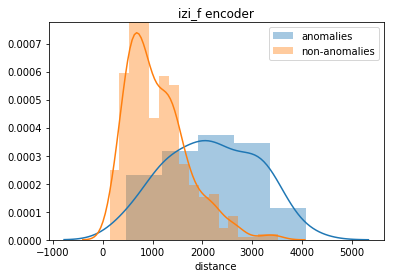

In [33]:
sns.distplot(loss_izi_f[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss_izi_f[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.title('izi encoder')
plt.legend()

In [ ]:
train_izi(10, f=True)
torch.save(encoder.state_dict(), './models/izi_f_encoder.ckpt')

In [ ]:
z = encoder(train_data_mnist.to(device))
gen_fake = generator(z.to(device))
loss_izi = Anomaly_score(Variable(train_data_mnist).to(device), gen_fake, 10)
roc_auc = roc_auc_score(train_label_mnist.int(), loss.cpu().detach().numpy())
print('roc_auc:', roc_auc)
sns.distplot(loss_izi_f[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss_izi_f[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.title('izi_f encoder')
plt.legend()